In [1]:
# === Five-Strategy Comparison Notebook ===
# VolGAN is the Main Strategy - Compare Against Naive, Delta, Delta-Vega, Delta-Gamma

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_rel

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100

In [49]:
# === SECTION 1: Load All Results ===

# Load CSV files
results_naive = pd.read_csv('results_naive.csv')
results_delta = pd.read_csv('results_delta.csv')
results_deltavega = pd.read_csv('results_deltavega.csv')
results_deltagamma = pd.read_csv('results_gamma.csv')
results_volgan = pd.read_csv('../results_volgan_best.csv')

# Convert ALL date columns to datetime with error handling
for df in [results_naive, results_delta, results_deltavega, results_deltagamma, results_volgan]:
    df['start'] = pd.to_datetime(df['start'], errors='coerce')
    df['end'] = pd.to_datetime(df['end'], errors='coerce')
    
    # Drop rows with invalid dates
    df.dropna(subset=['start', 'end'], inplace=True)

# Add strategy labels
results_naive['strategy'] = 'Naive'
results_delta['strategy'] = 'Delta'
results_deltavega['strategy'] = 'Delta-Vega'
results_deltagamma['strategy'] = 'Delta-Gamma'
results_volgan['strategy'] = 'VolGAN'

results_all = pd.concat([results_naive, results_delta, results_deltavega, 
                         results_deltagamma, results_volgan], 
                        ignore_index=True)

# Check for data issues
print("\n" + "="*80)
print("Data Loading Diagnostics")
print("="*80)
for name, df in [('Naive', results_naive), ('Delta', results_delta), 
                  ('Delta-Vega', results_deltavega), ('Delta-Gamma', results_deltagamma), 
                  ('VolGAN', results_volgan)]:
    print(f"{name:15s}: {len(df)} rows, dates {df['start'].min()} to {df['end'].max()}")
    print(f"  Unique m0 values: {sorted(df['m0'].unique())}")
print("="*80)

print("="*80)
print("Data Loaded Successfully - VolGAN as Main Strategy")
print("="*80)
print(f"Total windows: {len(results_all)}")
print(f"\nBreakdown by strategy:")
print(results_all['strategy'].value_counts().sort_index())
print("="*80)


Data Loading Diagnostics
Naive          : 159 rows, dates 2020-01-02 00:00:00 to 2023-08-04 00:00:00
  Unique m0 values: [np.float64(0.75), np.float64(0.8), np.float64(0.9), np.float64(1.1)]
Delta          : 159 rows, dates 2020-01-02 00:00:00 to 2023-08-04 00:00:00
  Unique m0 values: [np.float64(0.75), np.float64(0.8), np.float64(0.9), np.float64(1.1)]
Delta-Vega     : 159 rows, dates 2020-01-02 00:00:00 to 2023-08-04 00:00:00
  Unique m0 values: [np.float64(0.75), np.float64(0.8), np.float64(0.9), np.float64(1.1)]
Delta-Gamma    : 159 rows, dates 2020-01-02 00:00:00 to 2023-08-04 00:00:00
  Unique m0 values: [np.float64(0.75), np.float64(0.8), np.float64(0.9), np.float64(1.1)]
VolGAN         : 159 rows, dates 2020-01-02 00:00:00 to 2023-08-04 00:00:00
  Unique m0 values: [np.float64(0.75), np.float64(0.8), np.float64(0.9), np.float64(1.1)]
Data Loaded Successfully - VolGAN as Main Strategy
Total windows: 795

Breakdown by strategy:
strategy
Delta          159
Delta-Gamma    159
Del

In [50]:
import pandas as pd

# Aggregate PnL summaries by strategy
pnl_summary = results_all.groupby('strategy').agg({
    'pnl_unhedged': ['mean', 'std', 'sum'],
    'pnl_hedged': ['mean', 'std', 'sum']
})

# Flatten multi-level columns
pnl_summary.columns = ['_'.join(col).strip() for col in pnl_summary.columns.values]

print(pnl_summary)


             pnl_unhedged_mean  pnl_unhedged_std  pnl_unhedged_sum  \
strategy                                                             
Delta                16.519182        193.583599           2626.55   
Delta-Gamma          16.519182        193.583599           2626.55   
Delta-Vega           16.519182        193.583599           2626.55   
Naive                16.519182        193.583599           2626.55   
VolGAN               16.519182        193.583599           2626.55   

             pnl_hedged_mean  pnl_hedged_std  pnl_hedged_sum  
strategy                                                      
Delta              -3.763163      213.415815     -598.342876  
Delta-Gamma         8.340346      209.281532     1326.115009  
Delta-Vega         14.782527      204.866702     2350.421733  
Naive              12.070050      200.888203     1919.137890  
VolGAN             -3.009306      120.907402     -478.479691  


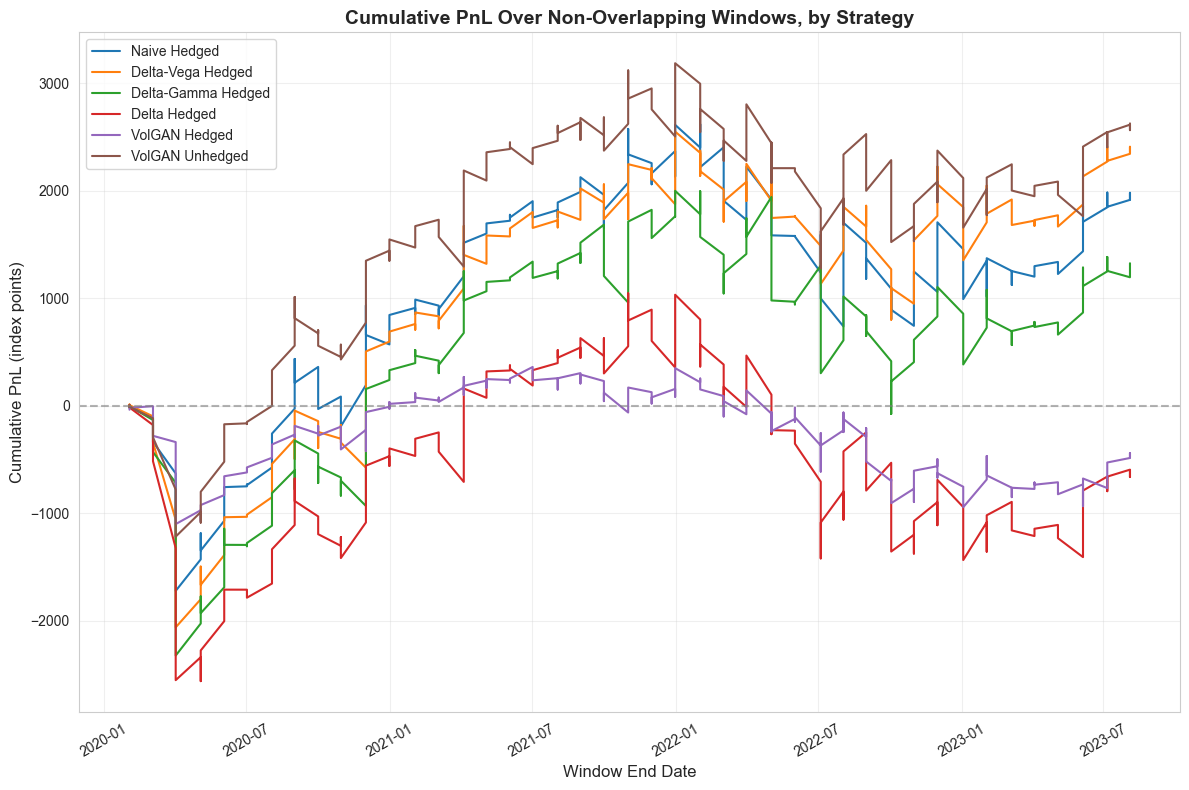

In [69]:
import matplotlib.pyplot as plt

# Sort results_all by window end date for consistency
res_all = results_all.sort_values('end').reset_index(drop=True)

# Calculate cumulative sums for each strategy separately
res_all['cum_unhedged'] = res_all.groupby('strategy')['pnl_unhedged'].cumsum()
res_all['cum_hedged'] = res_all.groupby('strategy')['pnl_hedged'].cumsum()

# Get unique strategies for plotting
strategies = res_all['strategy'].unique()

plt.figure(figsize=(12, 8))

# Plot cumulative pnl for each strategy
for strat in strategies:
    data = res_all[res_all['strategy'] == strat]
    plt.plot(data['end'], data['cum_hedged'], label=f'{strat} Hedged')
data = res_all[res_all['strategy'] == "Delta"]
plt.plot(data['end'], data['cum_unhedged'], label=f'{strat} Unhedged')
plt.axhline(0, color='gray', linestyle='--', alpha=0.6)
plt.title('Cumulative PnL Over Non-Overlapping Windows, by Strategy', fontsize=14, fontweight='bold')
plt.xlabel('Window End Date', fontsize=12)
plt.ylabel('Cumulative PnL (index points)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


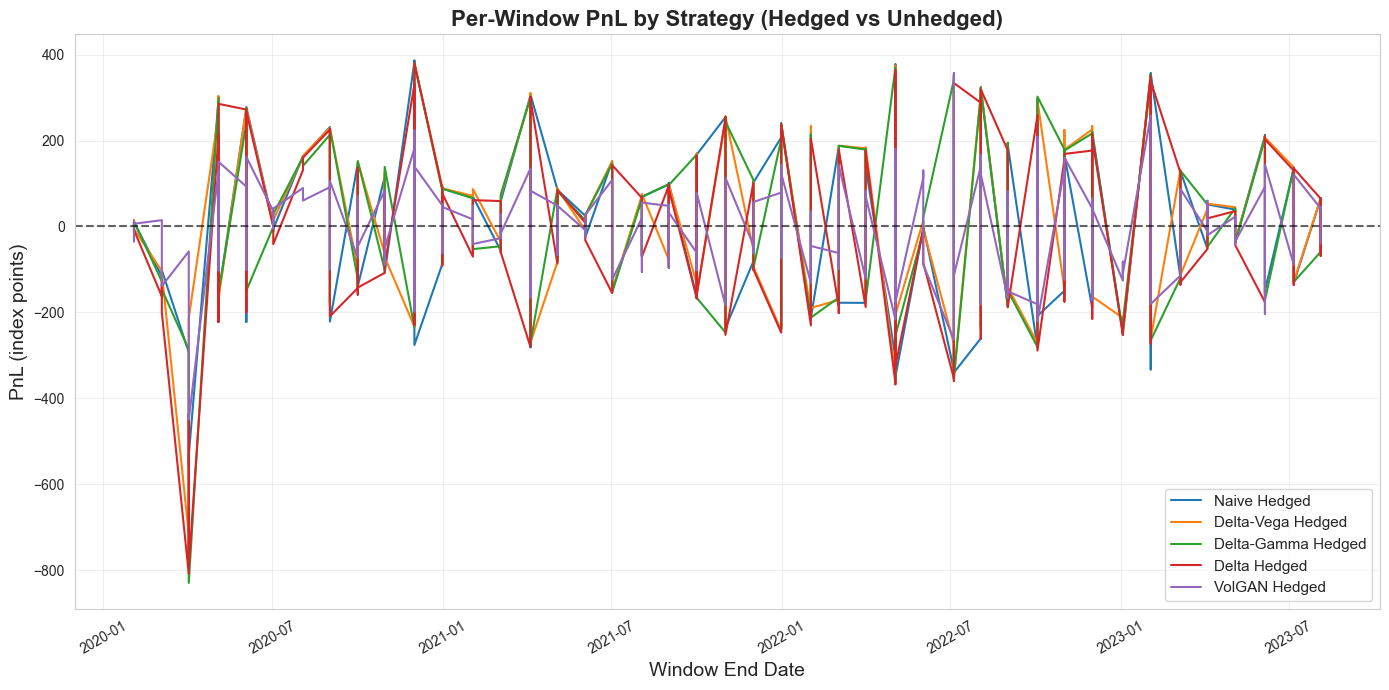

In [52]:
import matplotlib.pyplot as plt

# Sort by end date for consistency
res_all = results_all.sort_values('end').reset_index(drop=True)

# Get unique strategies
strategies = res_all['strategy'].unique()

plt.figure(figsize=(14, 7))

# Plot PnL by window, for each strategy
for strat in strategies:
    data = res_all[res_all['strategy'] == strat]
    plt.plot(data['end'], data['pnl_hedged'], label=f'{strat} Hedged')

plt.axhline(0, linestyle='--', color='black', alpha=0.6)
plt.title('Per-Window PnL by Strategy (Hedged vs Unhedged)', fontsize=16, fontweight='bold')
plt.xlabel('Window End Date', fontsize=14)
plt.ylabel('PnL (index points)', fontsize=14)
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


      Strategy  Total Days  Annualized Return  Annualized Volatility  \
0        Naive        1310         369.177670            3189.001366   
1   Delta-Vega        1310         452.142196            3252.158068   
2  Delta-Gamma        1310         255.099987            3322.241320   
3        Delta        1310        -115.101072            3387.871030   
4       VolGAN        1310         -92.043421            1919.345504   

   Max Drawdown  
0  -2202.918733  
1  -2071.323792  
2  -2318.434336  
3  -2565.762624  
4  -1546.365827  


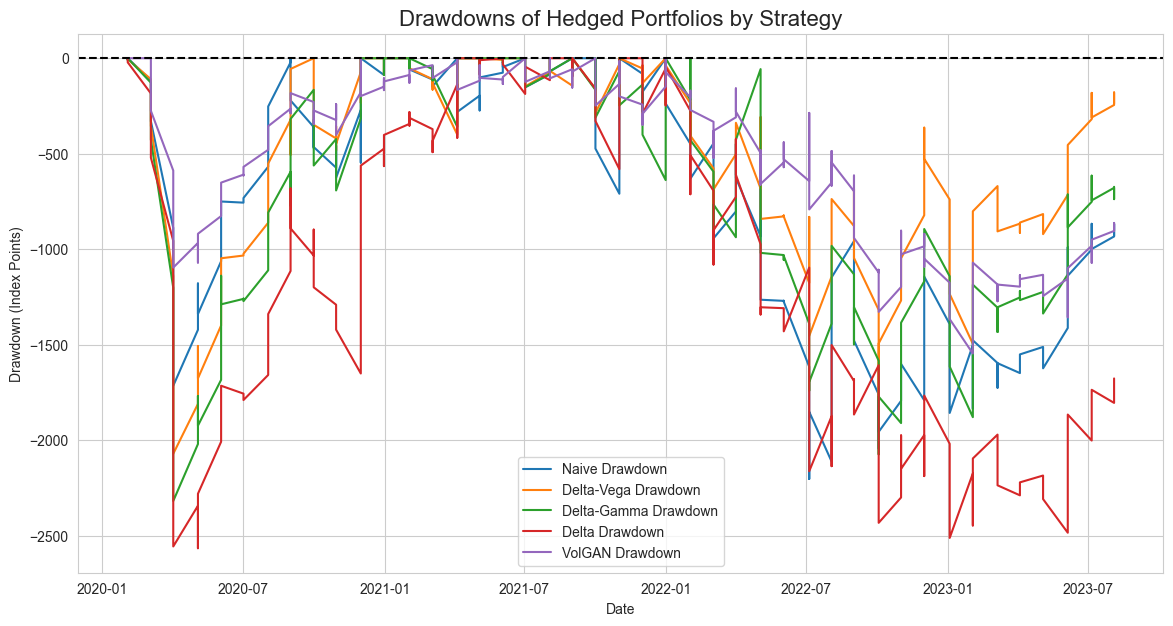

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def compute_drawdowns(cum_pnl):
    # Calculate running max
    running_max = np.maximum.accumulate(cum_pnl)
    # Calculate drawdowns as decline from running max
    drawdowns = cum_pnl - running_max
    return drawdowns

def annualized_return(cum_pnl, total_days):
    # Simple annualization assuming 252 trading days/year
    total_return = cum_pnl.iloc[-1]
    years = total_days / 252
    return (total_return / years)

def annualized_volatility(pnl, total_days):
    years = total_days / 252
    return pnl.std() * np.sqrt(252)

# Assume results_all with pnl_hedged, pnl_unhedged, sorted by 'end'
res_all = results_all.sort_values('end').reset_index(drop=True)

metrics = []

for strat in res_all['strategy'].unique():
    df = res_all[res_all['strategy'] == strat].copy()
    df = df.sort_values('end')
    total_days = (df['end'].iloc[-1] - df['start'].iloc[0]).days

    # Cumulative hedged pnl
    cum_hedged = df['pnl_hedged'].cumsum()
    # Compute drawdowns
    drawdowns = compute_drawdowns(cum_hedged)
    max_dd = drawdowns.min()

    # Annualized return and volatility
    ann_return = annualized_return(cum_hedged, total_days)
    ann_vol = annualized_volatility(df['pnl_hedged'], total_days)

    metrics.append({
        'Strategy': strat,
        'Total Days': total_days,
        'Annualized Return': ann_return,
        'Annualized Volatility': ann_vol,
        'Max Drawdown': max_dd
    })

metrics_df = pd.DataFrame(metrics)

print(metrics_df)

# Plot drawdowns for each strategy
plt.figure(figsize=(14, 7))
for strat in res_all['strategy'].unique():
    df = res_all[res_all['strategy'] == strat].sort_values('end')
    cum_hedged = df['pnl_hedged'].cumsum()
    drawdowns = compute_drawdowns(cum_hedged)
    plt.plot(df['end'], drawdowns, label=f"{strat} Drawdown")

plt.axhline(0, color='black', linestyle='--')
plt.title('Drawdowns of Hedged Portfolios by Strategy', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Drawdown (Index Points)')
plt.legend()
plt.grid(True)
plt.show()


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_19384\112788805.py:15: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\LENOVO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


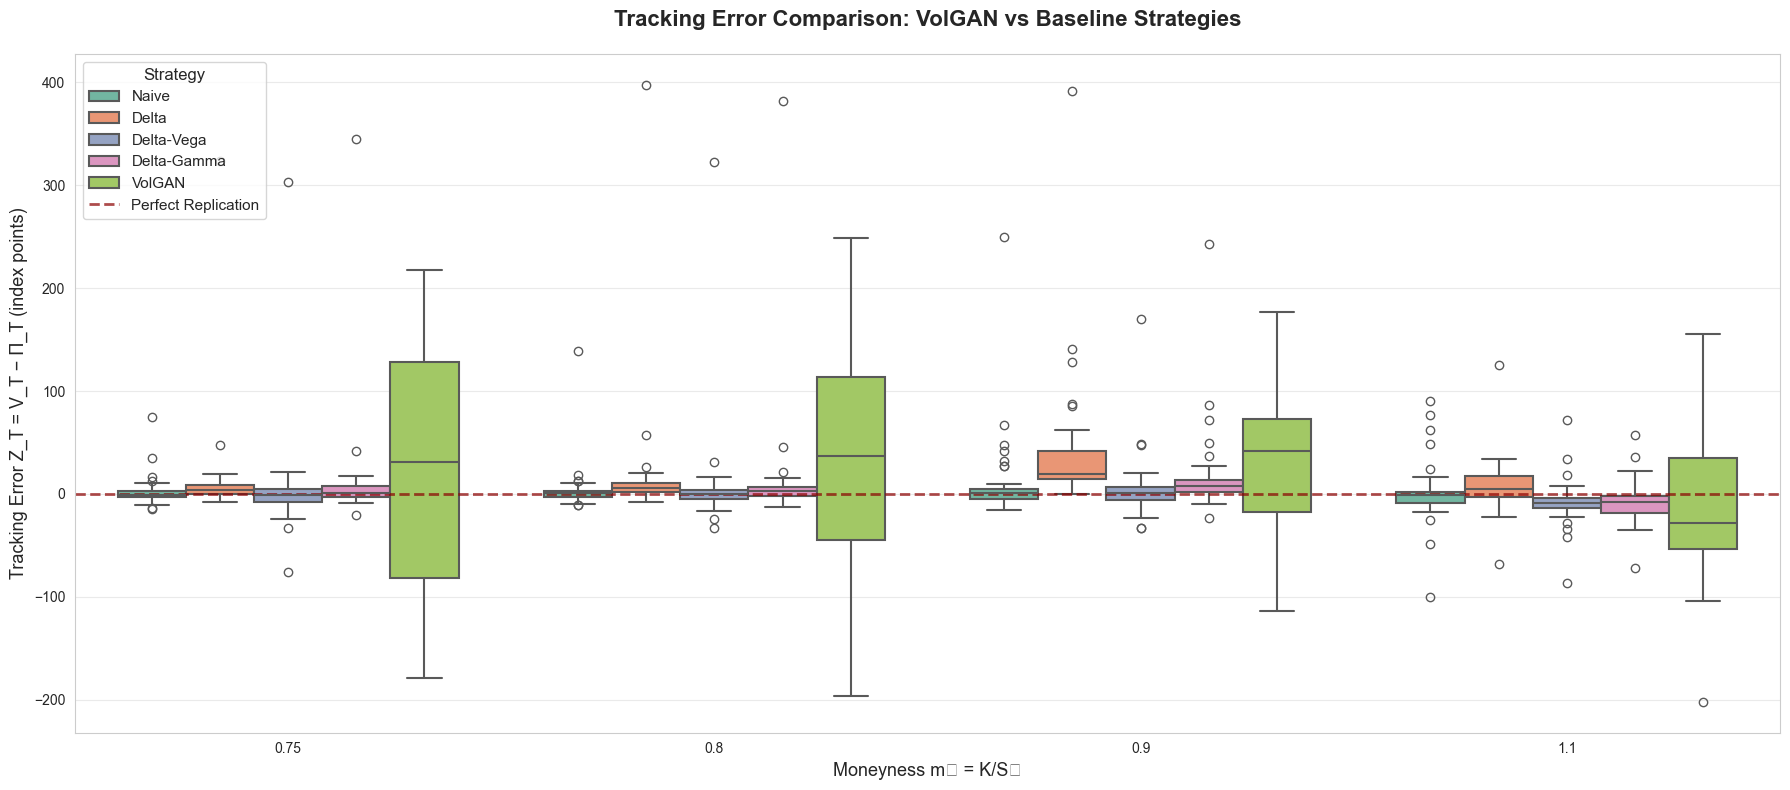

In [70]:
# === SECTION 2: Box Plot Comparison by Moneyness ===

plt.figure(figsize=(18, 8))
sns.boxplot(x='m0', y='tracking_error', hue='strategy', data=results_all, 
            palette='Set2', linewidth=1.5)

plt.title('Tracking Error Comparison: VolGAN vs Baseline Strategies', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Moneyness m₀ = K/S₀', fontsize=13)
plt.ylabel('Tracking Error Z_T = V_T − Π_T (index points)', fontsize=13)
plt.axhline(y=0, color='darkred', linestyle='--', linewidth=2, alpha=0.7, 
            label='Perfect Replication')
plt.legend(title='Strategy', fontsize=11, title_fontsize=12, loc='upper left')
plt.grid(axis='y', alpha=0.4)
plt.tight_layout()
plt.show()

In [71]:
# === SECTION 3: Summary Statistics Table ===

summary_all = results_all.groupby(['strategy', 'm0'])['tracking_error'].agg([
    ('Count', 'count'),
    ('Mean', 'mean'),
    ('Median', 'median'),
    ('Std Dev', 'std'),
    ('VaR 5%', lambda x: x.quantile(0.05)),
    ('VaR 1%', lambda x: x.quantile(0.01))
]).round(3)

print("\n" + "="*100)
print("Tracking Error Summary Statistics by Strategy and Moneyness")
print("="*100)
print(summary_all)
print("="*100)


Tracking Error Summary Statistics by Strategy and Moneyness
                  Count    Mean  Median  Std Dev   VaR 5%   VaR 1%
strategy    m0                                                    
Delta       0.75     36  14.241   3.904   53.947   -3.630   -7.137
            0.80     41  16.733   6.083   61.909   -5.567   -7.346
            0.90     43  39.332  19.603   63.101    5.448    0.647
            1.10     39   8.588   4.949   26.315  -12.430  -50.503
Delta-Gamma 0.75     36  11.911   0.498   57.995   -8.941  -16.571
            0.80     41  12.291   3.247   60.049  -10.571  -12.218
            0.90     43  16.718   7.408   40.237   -8.420  -17.850
            1.10     39  -9.005  -8.283   20.248  -32.799  -57.772
Delta-Vega  0.75     36   3.880  -1.327   53.886  -26.319  -60.927
            0.80     41   6.390   0.373   51.731  -16.839  -29.655
            0.90     43   4.653   0.850   30.318  -23.278  -33.182
            1.10     39  -8.349  -8.556   22.265  -35.158  -69.661
N

In [56]:
# === SECTION 4: Aggregate Performance Metrics ===

# Overall performance by strategy
perf_summary = results_all.groupby('strategy')['tracking_error'].agg([
    ('Mean |Error|', lambda x: x.abs().mean()),
    ('Median |Error|', lambda x: x.abs().median()),
    ('Std Dev', 'std'),
    ('RMSE', lambda x: np.sqrt((x**2).mean())),
    ('MAE', lambda x: x.abs().mean()),
    ('VaR 5%', lambda x: x.quantile(0.05)),
    ('CVaR 5%', lambda x: x[x <= x.quantile(0.05)].mean()),
    ('Min Error', lambda x: x.min()),
    ('Max Error', lambda x: x.max()),
]).round(3)

perf_summary = perf_summary.sort_values('Mean |Error|')

print("\n" + "="*100)
print("Overall Strategy Performance (Lower is Better)")
print("="*100)
print(perf_summary)
print("="*100)


Overall Strategy Performance (Lower is Better)
             Mean |Error|  Median |Error|  Std Dev     RMSE     MAE   VaR 5%  \
strategy                                                                       
Naive              12.149           3.696   29.442   29.685  12.149  -14.281   
Delta-Vega         15.823           6.440   41.453   41.359  15.823  -28.735   
Delta-Gamma        16.753           6.962   47.825   48.371  16.753  -22.767   
Delta              22.826           8.523   54.627   58.109  22.826   -6.377   
VolGAN             82.984          71.605   99.439  101.563  82.984 -126.959   

             CVaR 5%  Min Error  Max Error  
strategy                                    
Naive        -31.907   -100.027    249.936  
Delta-Vega   -46.406    -86.761    322.551  
Delta-Gamma  -33.038    -71.744    382.327  
Delta        -17.470    -67.935    397.756  
VolGAN      -161.537   -202.167    248.778  


In [57]:
# === SECTION 5: VolGAN Performance Ranking ===

print("\n" + "="*80)
print("VolGAN Performance Ranking")
print("="*80)

volgan_perf = perf_summary.loc['VolGAN']
print(f"\nVolGAN Metrics:")
print(volgan_perf)

for idx, (strategy, metrics) in enumerate(perf_summary.iterrows(), 1):
    if strategy == 'VolGAN':
        print(f"\n🎯 VolGAN Rank: #{idx} out of 5 strategies")
        print(f"   Position: {'BEST' if idx == 1 else 'COMPETITIVE' if idx <= 3 else 'NEEDS IMPROVEMENT'}")
        break

print("="*80)


VolGAN Performance Ranking

VolGAN Metrics:
Mean |Error|       82.984
Median |Error|     71.605
Std Dev            99.439
RMSE              101.563
MAE                82.984
VaR 5%           -126.959
CVaR 5%          -161.537
Min Error        -202.167
Max Error         248.778
Name: VolGAN, dtype: float64

🎯 VolGAN Rank: #5 out of 5 strategies
   Position: NEEDS IMPROVEMENT


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_19384\1647785051.py:14: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\LENOVO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


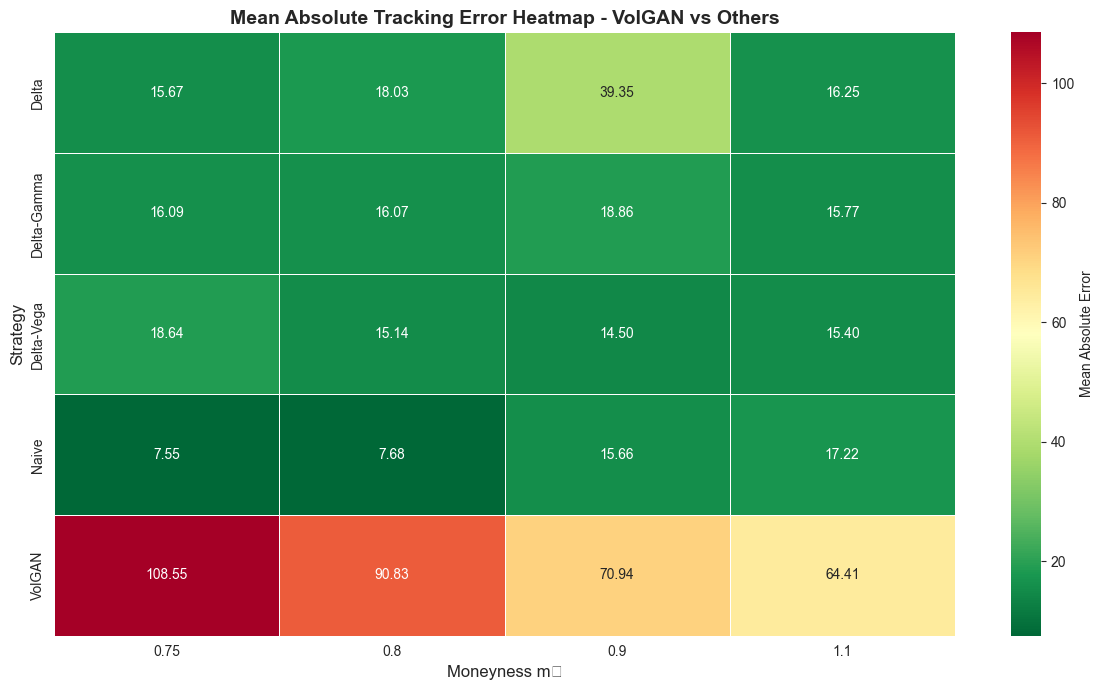

In [58]:
# === SECTION 6: Heatmap of Mean Absolute Errors ===

mae_pivot = results_all.groupby(['strategy', 'm0'])['tracking_error'].apply(
    lambda x: x.abs().mean()
).unstack()

plt.figure(figsize=(12, 7))
sns.heatmap(mae_pivot, annot=True, fmt='.2f', cmap='RdYlGn_r', 
            linewidths=0.5, cbar_kws={'label': 'Mean Absolute Error'})
plt.title('Mean Absolute Tracking Error Heatmap - VolGAN vs Others', 
          fontsize=14, fontweight='bold')
plt.xlabel('Moneyness m₀', fontsize=12)
plt.ylabel('Strategy', fontsize=12)
plt.tight_layout()
plt.show()

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_19384\2701008327.py:14: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\LENOVO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


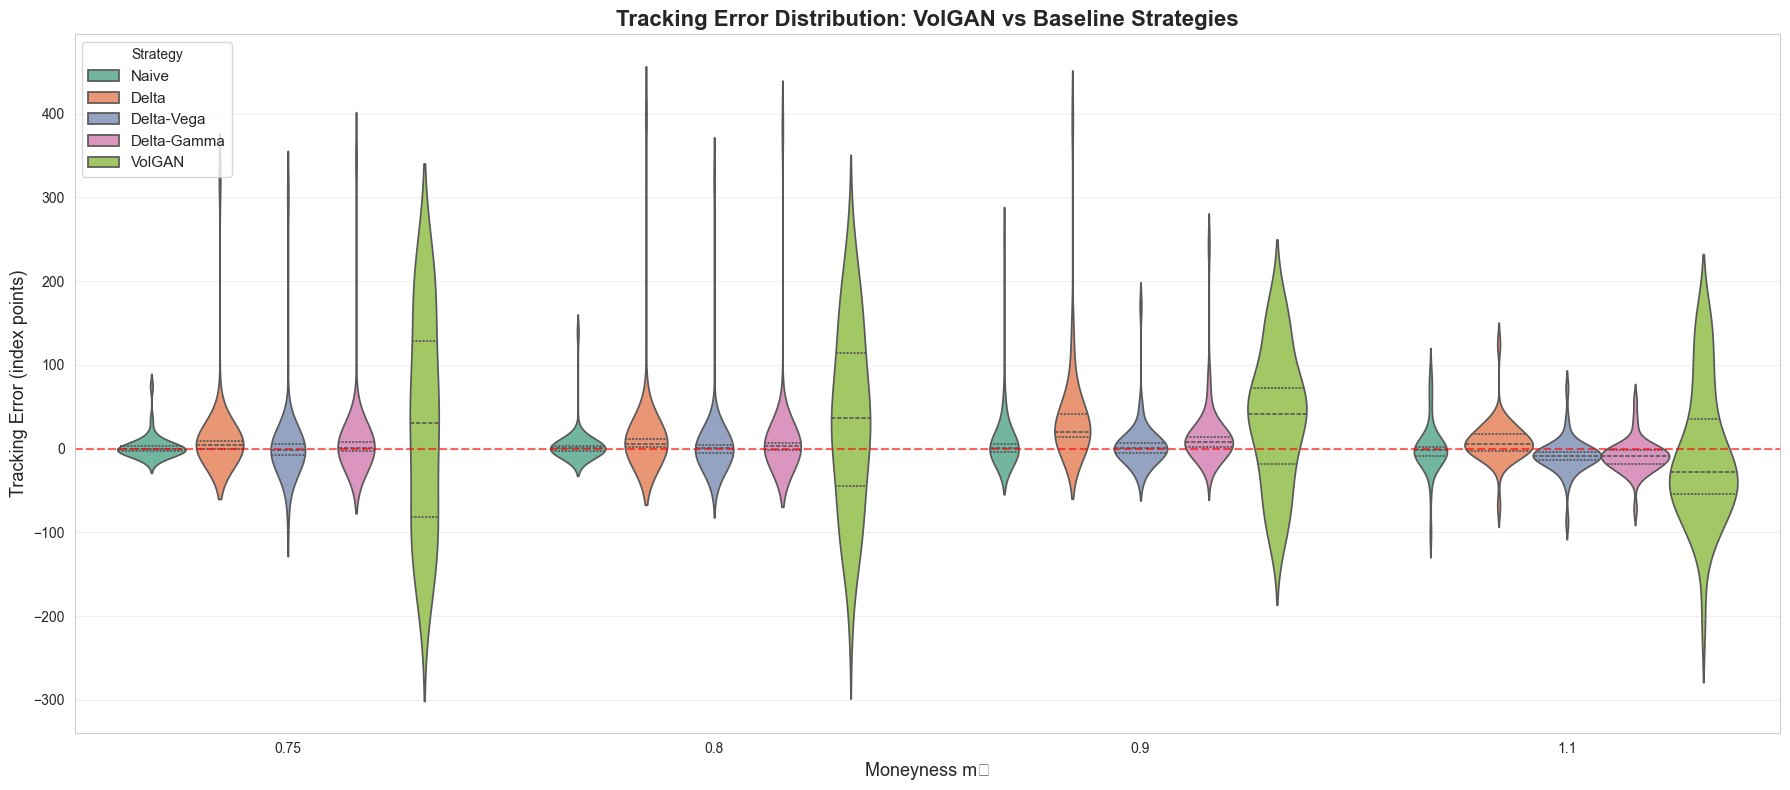

In [59]:
# === SECTION 7: Violin Plot (Distribution Comparison) ===

plt.figure(figsize=(18, 8))
sns.violinplot(x='m0', y='tracking_error', hue='strategy', data=results_all,
               palette='Set2', split=False, inner='quartile')

plt.title('Tracking Error Distribution: VolGAN vs Baseline Strategies', 
          fontsize=16, fontweight='bold')
plt.xlabel('Moneyness m₀', fontsize=13)
plt.ylabel('Tracking Error (index points)', fontsize=13)
plt.axhline(0, color='red', linestyle='--', alpha=0.6)
plt.legend(title='Strategy', fontsize=11, loc='upper left')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

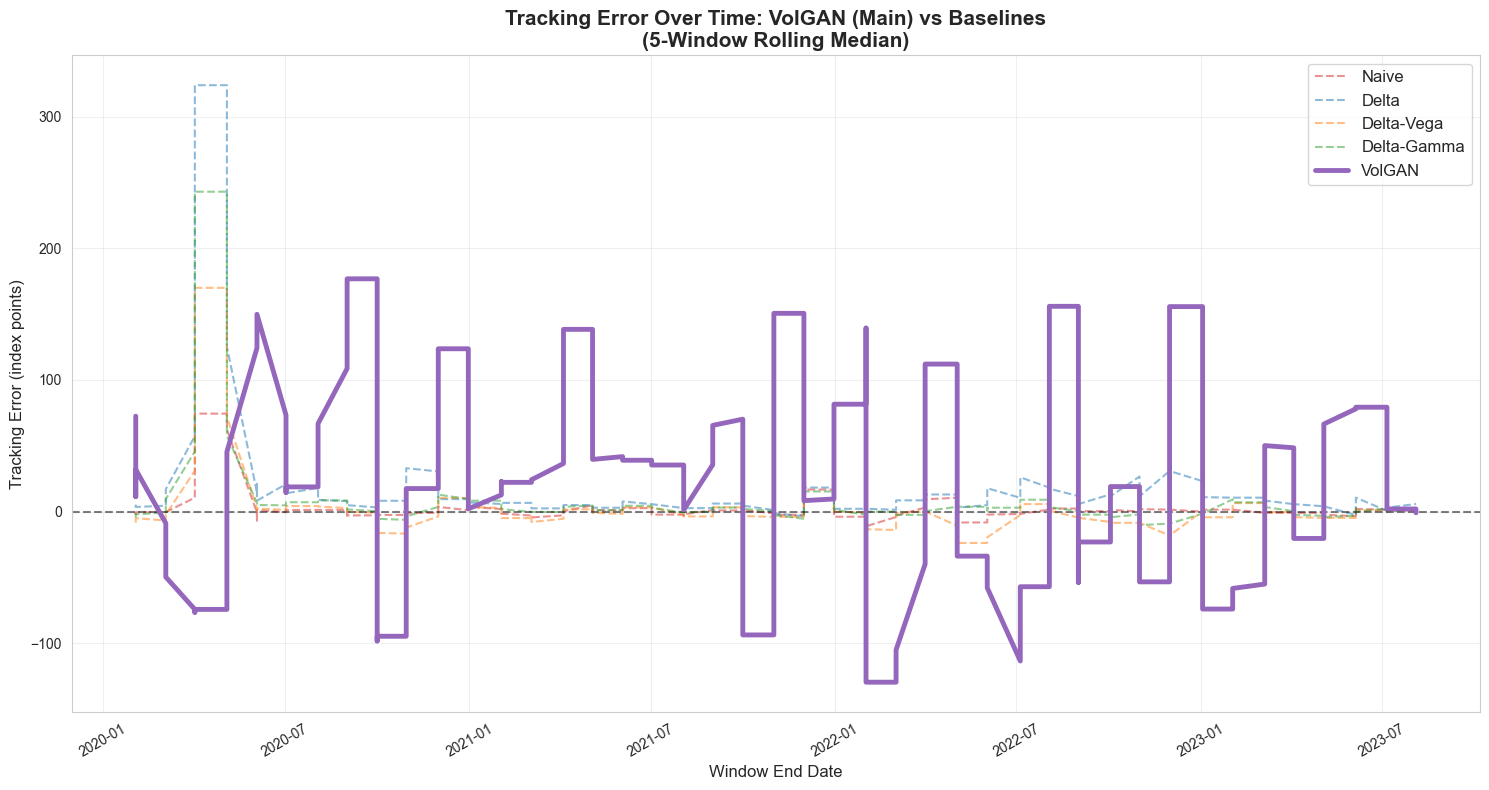

In [60]:
# === SECTION 8: Time Series Comparison (VolGAN Highlighted) ===

time_comparison = results_all.sort_values('end')

plt.figure(figsize=(15, 8))
strategy_colors = {
    'Naive': '#d62728',
    'Delta': '#1f77b4',
    'Delta-Vega': '#ff7f0e',
    'Delta-Gamma': '#2ca02c',
    'VolGAN': '#9467bd'
}

# Plot baselines first (lighter)
for strategy in ['Naive', 'Delta', 'Delta-Vega', 'Delta-Gamma']:
    subset = time_comparison[time_comparison['strategy'] == strategy]
    subset_sorted = subset.sort_values('end')
    plt.plot(subset_sorted['end'], 
             subset_sorted['tracking_error'].rolling(5, min_periods=1).median(),
             label=strategy, linewidth=1.5, alpha=0.5, color=strategy_colors[strategy], linestyle='--')

# Plot VolGAN last (darker, thicker)
subset = time_comparison[time_comparison['strategy'] == 'VolGAN']
subset_sorted = subset.sort_values('end')
plt.plot(subset_sorted['end'], 
         subset_sorted['tracking_error'].rolling(5, min_periods=1).median(),
         label='VolGAN', linewidth=3.5, alpha=1.0, color=strategy_colors['VolGAN'], zorder=10)

plt.axhline(0, color='black', linestyle='--', alpha=0.5)
plt.title('Tracking Error Over Time: VolGAN (Main) vs Baselines\n(5-Window Rolling Median)', 
          fontsize=15, fontweight='bold')
plt.xlabel('Window End Date', fontsize=12)
plt.ylabel('Tracking Error (index points)', fontsize=12)
plt.legend(fontsize=12, loc='best')
plt.grid(alpha=0.3)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

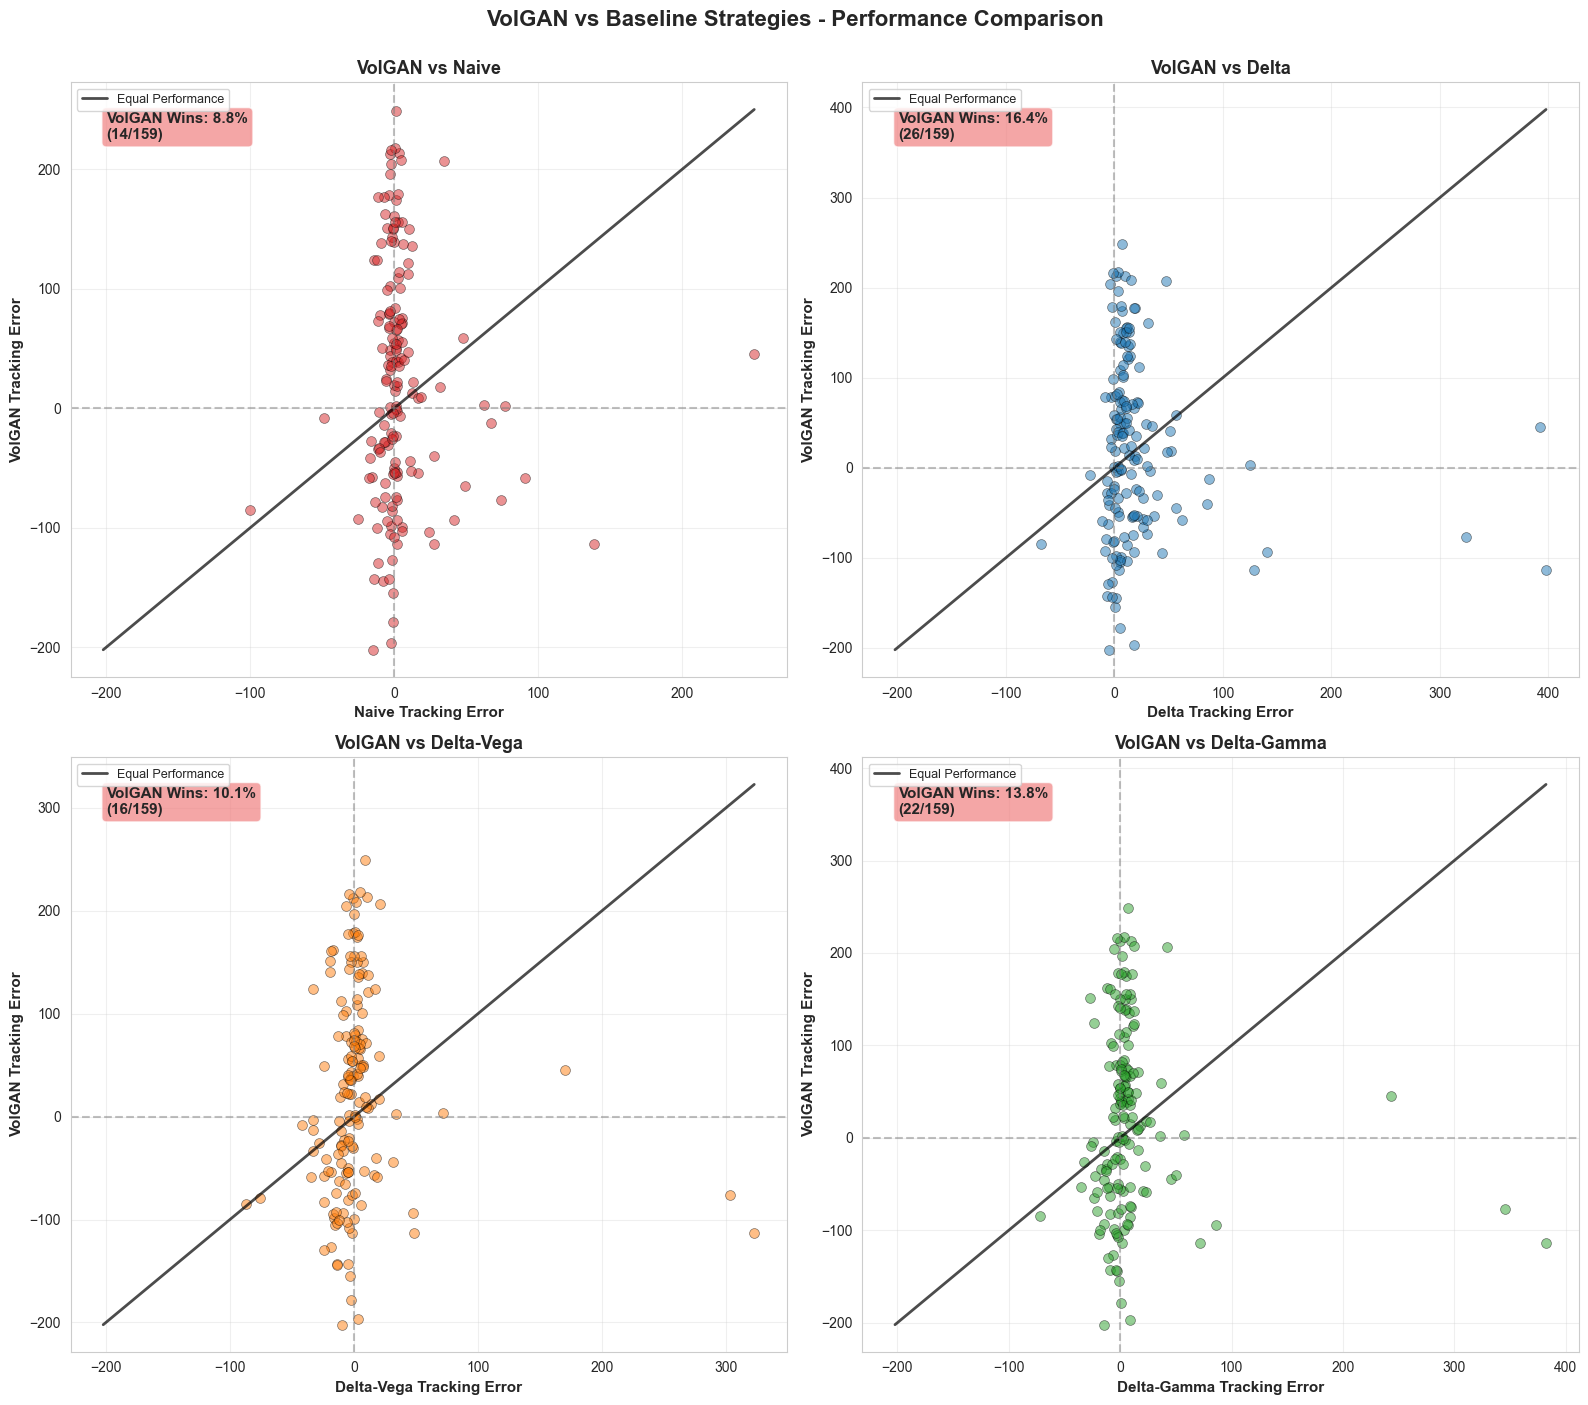

In [61]:
# === SECTION 9: Pairwise Scatter Plots (VolGAN vs Each Baseline) ===

fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.flatten()

strategies_to_compare = ['Naive', 'Delta', 'Delta-Vega', 'Delta-Gamma']
colors = {
    'Naive': '#d62728',
    'Delta': '#1f77b4',
    'Delta-Vega': '#ff7f0e',
    'Delta-Gamma': '#2ca02c',
}

for idx, other_strategy in enumerate(strategies_to_compare):
    ax = axes[idx]
    
    # Merge datasets
    other_df = results_all[results_all['strategy'] == other_strategy]
    volgan_df = results_all[results_all['strategy'] == 'VolGAN']
    
    merged = other_df.merge(
        volgan_df,
        on=['start', 'end', 'm0'],
        suffixes=(f'_{other_strategy}', '_VolGAN')
    )
    
    # Scatter plot
    ax.scatter(merged[f'tracking_error_{other_strategy}'], 
               merged['tracking_error_VolGAN'],
               alpha=0.5, s=50, color=colors[other_strategy], edgecolors='black', linewidth=0.5)
    
    # 45-degree line
    lims = [merged[[f'tracking_error_{other_strategy}', 'tracking_error_VolGAN']].min().min(),
            merged[[f'tracking_error_{other_strategy}', 'tracking_error_VolGAN']].max().max()]
    ax.plot(lims, lims, 'k-', linewidth=2, alpha=0.7, label='Equal Performance')
    
    ax.axhline(0, color='gray', linestyle='--', alpha=0.5)
    ax.axvline(0, color='gray', linestyle='--', alpha=0.5)
    
    ax.set_xlabel(f'{other_strategy} Tracking Error', fontsize=11, fontweight='bold')
    ax.set_ylabel('VolGAN Tracking Error', fontsize=11, fontweight='bold')
    ax.set_title(f'VolGAN vs {other_strategy}', fontsize=13, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(alpha=0.3)
    
    # Add win rate box
    volgan_wins = (merged['tracking_error_VolGAN'].abs() < 
                   merged[f'tracking_error_{other_strategy}'].abs()).sum()
    total = len(merged)
    win_pct = 100 * volgan_wins / total
    
    ax.text(0.05, 0.95, f'VolGAN Wins: {win_pct:.1f}%\n({volgan_wins}/{total})',
            transform=ax.transAxes, fontsize=11, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='yellow' if win_pct > 50 else 'lightcoral', alpha=0.7),
            fontweight='bold')

plt.suptitle('VolGAN vs Baseline Strategies - Performance Comparison', 
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

In [62]:
# === SECTION 10: VolGAN Win Rate Analysis (MAIN SECTION) ===

print("\n" + "="*80)
print("🎯 VolGAN WIN RATE ANALYSIS - MAIN RESULTS")
print("="*80)
print("(Lower Absolute Tracking Error = Win for VolGAN)")
print("="*80)

win_rates = []
for other_strategy in ['Naive', 'Delta', 'Delta-Vega', 'Delta-Gamma']:
    other_df = results_all[results_all['strategy'] == other_strategy]
    volgan_df = results_all[results_all['strategy'] == 'VolGAN']
    
    merged = other_df.merge(volgan_df, on=['start', 'end', 'm0'], 
                           suffixes=(f'_{other_strategy}', '_VolGAN'))
    
    volgan_wins = (merged['tracking_error_VolGAN'].abs() < 
                   merged[f'tracking_error_{other_strategy}'].abs()).sum()
    baseline_wins = (merged[f'tracking_error_{other_strategy}'].abs() < 
                     merged['tracking_error_VolGAN'].abs()).sum()
    ties = len(merged) - volgan_wins - baseline_wins
    total = len(merged)
    
    win_rates.append({
        'Baseline Strategy': other_strategy,
        'VolGAN Wins': volgan_wins,
        'Baseline Wins': baseline_wins,
        'Ties': ties,
        'Total Matchups': total,
        'VolGAN Win Rate (%)': round(100 * volgan_wins / total, 1),
        'Baseline Win Rate (%)': round(100 * baseline_wins / total, 1)
    })

win_rate_df = pd.DataFrame(win_rates)
print(win_rate_df.to_string(index=False))
print("="*80)

# Summary
total_volgan_wins = win_rate_df['VolGAN Wins'].sum()
total_matchups = win_rate_df['Total Matchups'].sum()
overall_win_rate = 100 * total_volgan_wins / total_matchups

print(f"\n📊 VolGAN OVERALL WIN RATE: {overall_win_rate:.1f}% ({total_volgan_wins}/{total_matchups} matchups)")
print("="*80)


🎯 VolGAN WIN RATE ANALYSIS - MAIN RESULTS
(Lower Absolute Tracking Error = Win for VolGAN)
Baseline Strategy  VolGAN Wins  Baseline Wins  Ties  Total Matchups  VolGAN Win Rate (%)  Baseline Win Rate (%)
            Naive           14            145     0             159                  8.8                   91.2
            Delta           26            133     0             159                 16.4                   83.6
       Delta-Vega           16            143     0             159                 10.1                   89.9
      Delta-Gamma           22            137     0             159                 13.8                   86.2

📊 VolGAN OVERALL WIN RATE: 12.3% (78/636 matchups)


In [63]:
# === SECTION 11: Mean Error Comparison (VolGAN vs Baselines) ===

print("\n" + "="*80)
print("VolGAN Mean Absolute Error vs Baselines")
print("="*80)

error_comparison = []
for other_strategy in ['Naive', 'Delta', 'Delta-Vega', 'Delta-Gamma']:
    other_df = results_all[results_all['strategy'] == other_strategy]
    volgan_df = results_all[results_all['strategy'] == 'VolGAN']
    
    merged = other_df.merge(volgan_df, on=['start', 'end', 'm0'], 
                           suffixes=(f'_{other_strategy}', '_VolGAN'))
    
    volgan_mae = merged['tracking_error_VolGAN'].abs().mean()
    baseline_mae = merged[f'tracking_error_{other_strategy}'].abs().mean()
    improvement = ((baseline_mae - volgan_mae) / baseline_mae * 100) if baseline_mae != 0 else 0
    
    error_comparison.append({
        'Baseline Strategy': other_strategy,
        'VolGAN MAE': round(volgan_mae, 3),
        'Baseline MAE': round(baseline_mae, 3),
        'VolGAN Advantage (%)': round(improvement, 1),
        'Status': '✓ Better' if improvement > 0 else '✗ Worse'
    })

error_comparison_df = pd.DataFrame(error_comparison).sort_values('VolGAN Advantage (%)', ascending=False)
print(error_comparison_df.to_string(index=False))
print("="*80)


VolGAN Mean Absolute Error vs Baselines
Baseline Strategy  VolGAN MAE  Baseline MAE  VolGAN Advantage (%)  Status
            Delta      82.984        22.826                -263.6 ✗ Worse
      Delta-Gamma      82.984        16.753                -395.3 ✗ Worse
       Delta-Vega      82.984        15.823                -424.4 ✗ Worse
            Naive      82.984        12.149                -583.1 ✗ Worse


In [64]:
# === SECTION 12: Statistical Significance Tests (VolGAN vs Baselines) ===

print("\n" + "="*80)
print("Paired T-Test: VolGAN vs Each Baseline Strategy")
print("(p < 0.05 indicates statistically significant difference)")
print("="*80)

ttest_results = []
for other_strategy in ['Naive', 'Delta', 'Delta-Vega', 'Delta-Gamma']:
    other_df = results_all[results_all['strategy'] == other_strategy]
    volgan_df = results_all[results_all['strategy'] == 'VolGAN']
    
    merged = other_df.merge(volgan_df, on=['start', 'end', 'm0'], 
                           suffixes=(f'_{other_strategy}', '_VolGAN'))
    
    # Paired t-test on absolute errors
    t_stat, p_value = ttest_rel(
        merged['tracking_error_VolGAN'].abs(),
        merged[f'tracking_error_{other_strategy}'].abs()
    )
    
    sig = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "NS"
    result_text = "VolGAN Better ✓" if t_stat < 0 else "VolGAN Worse ✗" if t_stat > 0 else "Equal"
    
    ttest_results.append({
        'Baseline': other_strategy,
        'T-Statistic': round(t_stat, 4),
        'P-Value': round(p_value, 4),
        'Sig': sig,
        'Result': result_text
    })
    
    print(f"\nVolGAN vs {other_strategy}:")
    print(f"  T-statistic: {t_stat:.4f}")
    print(f"  P-value: {p_value:.4f} {sig}")
    if p_value < 0.05:
        if t_stat < 0:
            print(f"  ✓ VolGAN is significantly BETTER (p < 0.05)")
        else:
            print(f"  ✗ VolGAN is significantly WORSE (p < 0.05)")
    else:
        print(f"  — No significant difference (p >= 0.05)")

print("\n" + "="*80)

ttest_df = pd.DataFrame(ttest_results)


Paired T-Test: VolGAN vs Each Baseline Strategy
(p < 0.05 indicates statistically significant difference)

VolGAN vs Naive:
  T-statistic: 13.2552
  P-value: 0.0000 ***
  ✗ VolGAN is significantly WORSE (p < 0.05)

VolGAN vs Delta:
  T-statistic: 9.1971
  P-value: 0.0000 ***
  ✗ VolGAN is significantly WORSE (p < 0.05)

VolGAN vs Delta-Vega:
  T-statistic: 11.8611
  P-value: 0.0000 ***
  ✗ VolGAN is significantly WORSE (p < 0.05)

VolGAN vs Delta-Gamma:
  T-statistic: 11.0680
  P-value: 0.0000 ***
  ✗ VolGAN is significantly WORSE (p < 0.05)



In [65]:
# === SECTION 13: VolGAN by Moneyness ===

print("\n" + "="*80)
print("VolGAN Performance by Moneyness")
print("="*80)

volgan_by_moneyness = results_volgan.groupby('m0')['tracking_error'].agg([
    ('Count', 'count'),
    ('Mean Error', 'mean'),
    ('Mean |Error|', lambda x: x.abs().mean()),
    ('Std Dev', 'std'),
    ('RMSE', lambda x: np.sqrt((x**2).mean())),
    ('Min', 'min'),
    ('Max', 'max'),
]).round(3)

print(volgan_by_moneyness)
print("="*80)


VolGAN Performance by Moneyness
      Count  Mean Error  Mean |Error|  Std Dev     RMSE      Min      Max
m0                                                                       
0.75     36      26.720       108.548  125.789  126.875 -178.537  217.659
0.80     41      33.940        90.833  107.190  111.182 -196.584  248.778
0.90     43      36.042        70.939   77.386   84.548 -113.488  176.831
1.10     39      -9.916        64.414   79.895   79.485 -202.167  155.455


In [66]:
# === SECTION 14: Export Summary Report ===

# Save comprehensive summary to CSV
perf_summary.to_csv('volgan_comparison_summary.csv')
win_rate_df.to_csv('volgan_win_rates.csv', index=False)
error_comparison_df.to_csv('volgan_error_comparison.csv', index=False)
ttest_df.to_csv('volgan_ttest_results.csv', index=False)
volgan_by_moneyness.to_csv('volgan_by_moneyness.csv')

print("\n" + "="*80)
print("✓ VolGAN Comparison Analysis Complete!")
print("="*80)
print("Summary files saved:")
print("  - volgan_comparison_summary.csv")
print("  - volgan_win_rates.csv")
print("  - volgan_error_comparison.csv")
print("  - volgan_ttest_results.csv")
print("  - volgan_by_moneyness.csv")
print("="*80)


✓ VolGAN Comparison Analysis Complete!
Summary files saved:
  - volgan_comparison_summary.csv
  - volgan_win_rates.csv
  - volgan_error_comparison.csv
  - volgan_ttest_results.csv
  - volgan_by_moneyness.csv


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_19384\2304202810.py:12: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  filtered_df = df.groupby(group_col, group_keys=False).apply(iqr_filter)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_19384\2304202810.py:34: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  plt.tight_layout()


Original size: 795, Filtered size: 718


C:\Users\LENOVO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


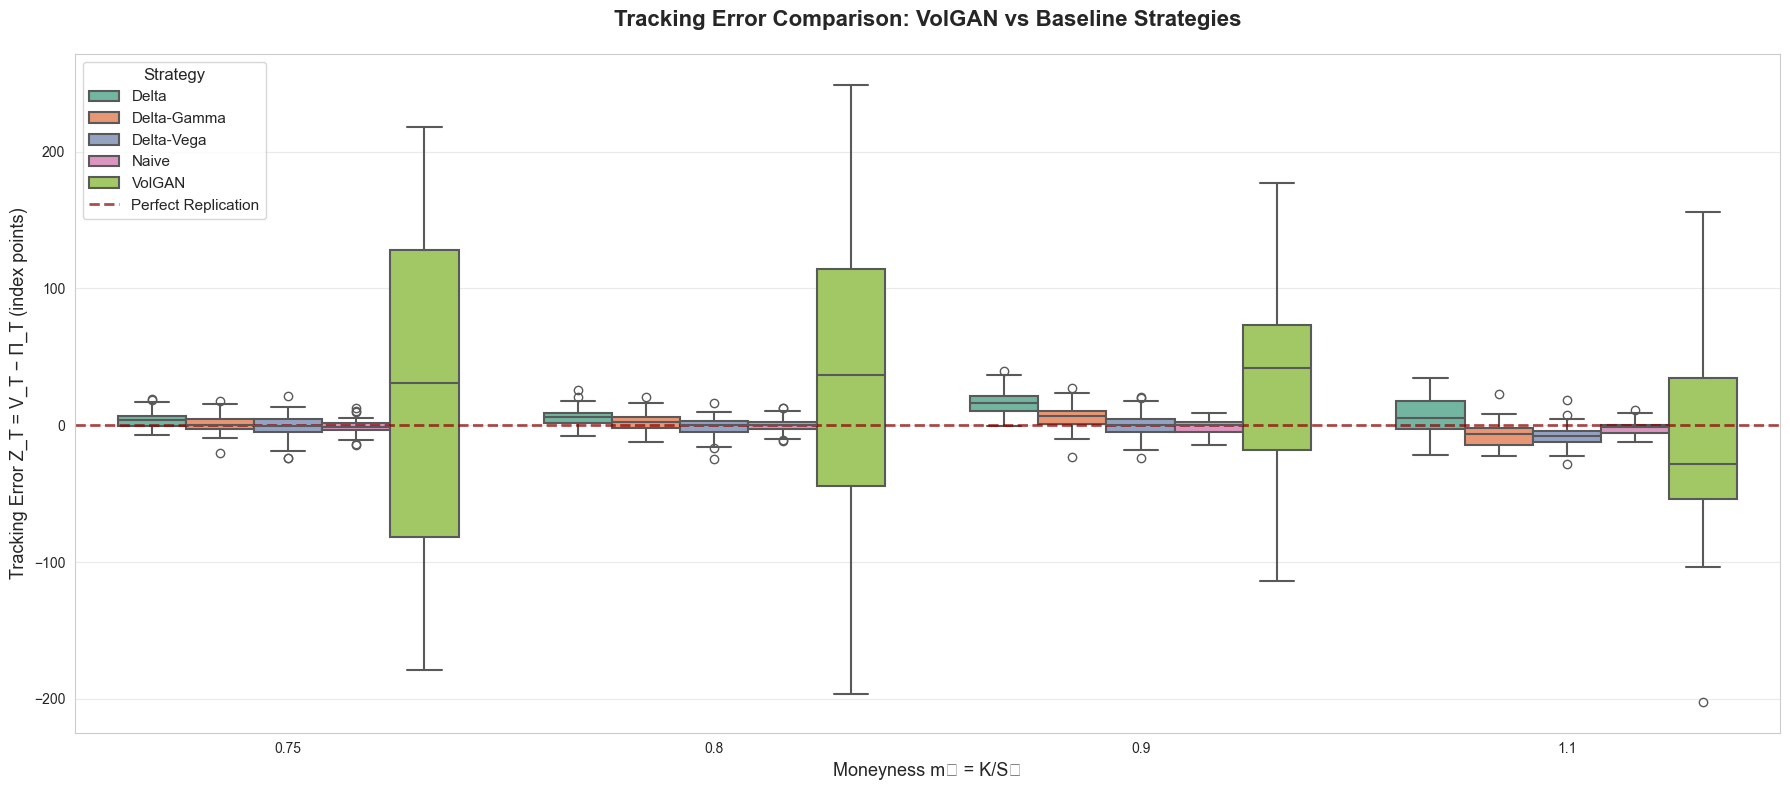

In [67]:
import pandas as pd

def remove_outliers_iqr(df, group_col, value_col):
    def iqr_filter(group):
        Q1 = group[value_col].quantile(0.25)
        Q3 = group[value_col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        return group[(group[value_col] >= lower_bound) & (group[value_col] <= upper_bound)]
    
    filtered_df = df.groupby(group_col, group_keys=False).apply(iqr_filter)
    return filtered_df

# Usage:
filtered_results = remove_outliers_iqr(results_all, 'strategy', 'tracking_error')

# Check data size before and after
print(f"Original size: {len(results_all)}, Filtered size: {len(filtered_results)}")
# === SECTION 2: Box Plot Comparison by Moneyness ===

plt.figure(figsize=(18, 8))
sns.boxplot(x='m0', y='tracking_error', hue='strategy', data=filtered_results, 
            palette='Set2', linewidth=1.5)

plt.title('Tracking Error Comparison: VolGAN vs Baseline Strategies', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Moneyness m₀ = K/S₀', fontsize=13)
plt.ylabel('Tracking Error Z_T = V_T − Π_T (index points)', fontsize=13)
plt.axhline(y=0, color='darkred', linestyle='--', linewidth=2, alpha=0.7, 
            label='Perfect Replication')
plt.legend(title='Strategy', fontsize=11, title_fontsize=12, loc='upper left')
plt.grid(axis='y', alpha=0.4)
plt.tight_layout()
plt.show()


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_19384\1705082584.py:14: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\LENOVO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


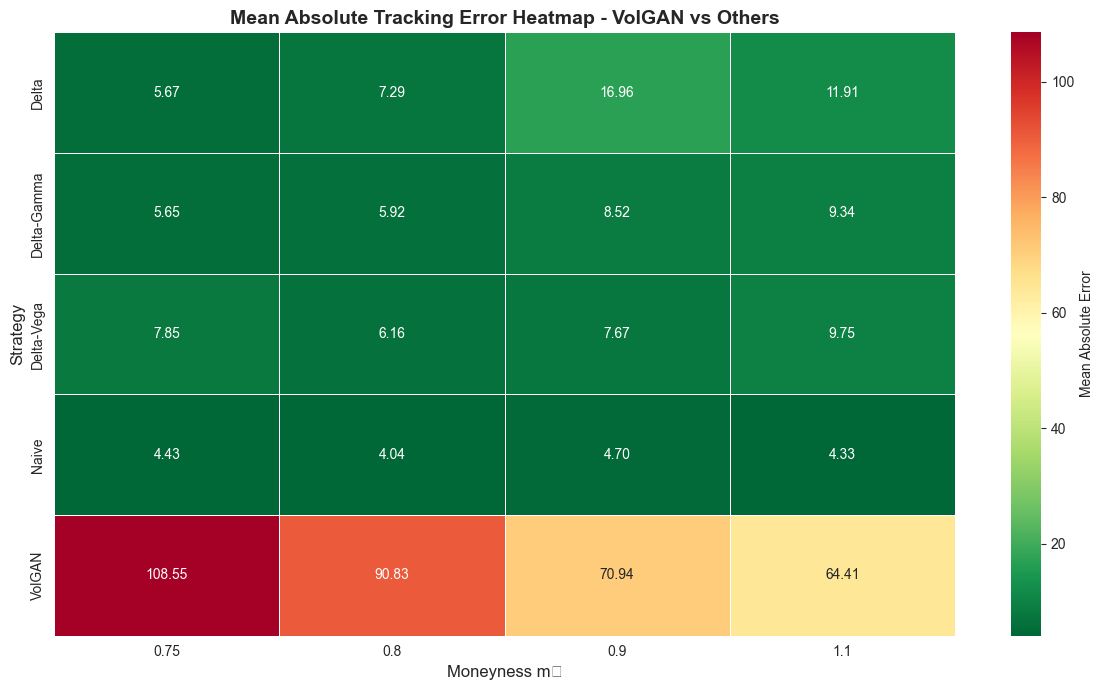

In [68]:
# === SECTION 6: Heatmap of Mean Absolute Errors ===

mae_pivot = filtered_results.groupby(['strategy', 'm0'])['tracking_error'].apply(
    lambda x: x.abs().mean()
).unstack()

plt.figure(figsize=(12, 7))
sns.heatmap(mae_pivot, annot=True, fmt='.2f', cmap='RdYlGn_r', 
            linewidths=0.5, cbar_kws={'label': 'Mean Absolute Error'})
plt.title('Mean Absolute Tracking Error Heatmap - VolGAN vs Others', 
          fontsize=14, fontweight='bold')
plt.xlabel('Moneyness m₀', fontsize=12)
plt.ylabel('Strategy', fontsize=12)
plt.tight_layout()
plt.show()